# Zero-Shot Object Detection with Gemma 3 - IT model
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/lab176344/vlm-notebookss/blob/main/notebooks/inference/exploration-gemma3.ipynb)

Google's Gemma 3  is an open weights research release which comes in 1b, 4b, 12b and 27b parameters with advanced capabilities optimized for a variety of vision-language use cases, including OCR, captioning, visual reasoning, summarization, question answering, code, and more. It is a multilingual model trained to excel in 23 languages in vision and language.

## Environment setup

### Configure your API keys

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.


In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Wed Mar 12 10:53:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             28W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs all required python libraries, including [`maestro`](https://github.com/roboflow/maestro) for Qwen2.5-VL and [`supervision`](https://github.com/roboflow/supervision) for visualization.

In [3]:
! pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

! pip install supervision opencv-python matplotlib requests numpy


  Cloning https://github.com/huggingface/transformers (to revision v4.49.0-Gemma-3) to /tmp/pip-req-build-2j6g8ce4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-2j6g8ce4
  Running command git checkout -q 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Resolved https://github.com/huggingface/transformers to commit 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load Gemma 3 model, and do necessary imports


In [4]:
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
import torch
import requests
import cv2
import numpy as np
import json
import supervision as sv
from matplotlib import pyplot as plt
import re

model_id = "google/gemma-3-4b-it"

processor = AutoProcessor.from_pretrained(model_id)
model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.bfloat16
).eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Zero Shot Object Detection
Loads the Aya-8B model model (and its processor) from Hugging Face, preparing the model for inference.

```json
{
  "workers": [
    {
      "x1": 335,
      "y1": 346,
      "x2": 523,
      "y2": 488
    },
    {
      "x1": 433,
      "y1": 346,
      "x2": 623,
      "y2": 488
    },
    {
      "x1": 533,
      "y1": 346,
      "x2": 723,
      "y2": 488
    },
    {
      "x1": 633,
      "y1": 346,
      "x2": 823,
      "y2": 488
    }
  ]
}
```
[[335, 346, 523, 488], [433, 346, 623, 488], [533, 346, 723, 488], [633, 346, 823, 488]]


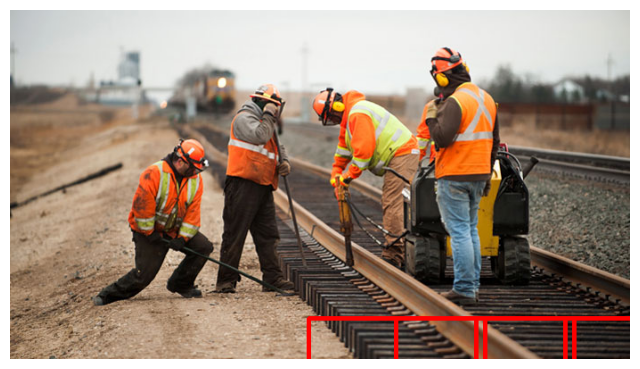

In [5]:
image_url = "https://www.minneapolisfed.org/-/media/images/pubs/fedgaz/15-04/key-images/working-on-the-railroad-key.jpg"
response = requests.get(image_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
resolution_wh = (860,860) # Aya Input resolution



messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {"role": "user",
     "content": [
       {"type": "image", "url": image_url},
        {"type": "text", "text": "Find the persons in the image. Return the bounding box coordinates, x1, y1, x2, y2 in json with keys as the label and values x1, y1, x2, y2"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt").to(model.device, dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=1000, do_sample=False).to(model.device)
    generation = generation[0][input_len:]

text_response = processor.decode(generation, skip_special_tokens=True)

print(text_response)

# Visualise the output
json_match = re.search(r'\{[\s\S]*\}', text_response)
if json_match:
    json_data = json_match.group(0)
    bbox_data = json.loads(json_data)
else:
    raise ValueError("JSON data not found in response.")
image = cv2.resize(image, resolution_wh)
bboxes = []
class_ids = []
class_id = 0 # Person
for idx, (key, value) in enumerate(bbox_data.items()):
    for bbox in value:
      if isinstance(bbox, dict):
        x1, y1, x2, y2 = bbox["x1"], bbox["y1"], bbox["x2"], bbox["y2"]
        bboxes.append([x1, y1, x2, y2])
        class_ids.append(class_id)
print(bboxes)
bboxes = np.array(bboxes)
class_ids = np.array(class_ids)

bounding_box_annotator = sv.BoxAnnotator(color=sv.Color.RED, thickness=3)
bbox_xyxy = sv.Detections(xyxy=bboxes, class_id=class_ids)
annotated_image = bounding_box_annotator.annotate(scene=image, detections=bbox_xyxy)
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()


# To do: Checked if it is not working because of resizing issue

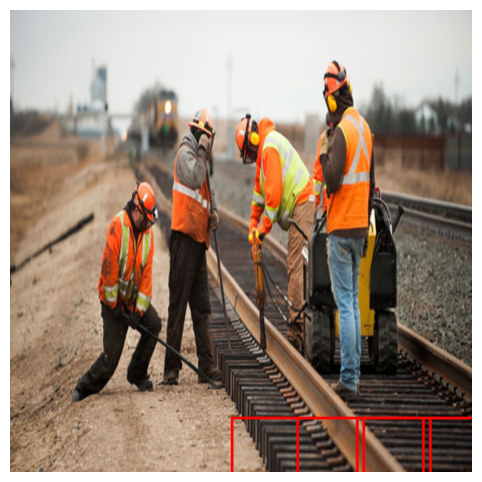

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
original_h, original_w = image.shape[:2]

resolution_wh = (860, 860)  # Gemma 3 input image dim
image_resized = cv2.resize(image, resolution_wh)

bboxes = []  # List of bounding boxes (x1, y1, x2, y2)
class_ids = []
class_id = 0

for key, value in bbox_data.items():
    for bbox in value:
        if isinstance(bbox, dict):
            x1, y1, x2, y2 = bbox["x1"], bbox["y1"], bbox["x2"], bbox["y2"]

            # Scale bounding box to the resized image
            x1 = int(x1 * resolution_wh[0] / original_w)
            y1 = int(y1 * resolution_wh[1] / original_h)
            x2 = int(x2 * resolution_wh[0] / original_w)
            y2 = int(y2 * resolution_wh[1] / original_h)

            bboxes.append([x1, y1, x2, y2])
            class_ids.append(class_id)

bboxes = np.array(bboxes)
class_ids = np.array(class_ids)

for bbox in bboxes:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(image_resized, (x1, y1), (x2, y2), (0, 0, 255), 3)

image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


# Counting

Analayse the model on counting task


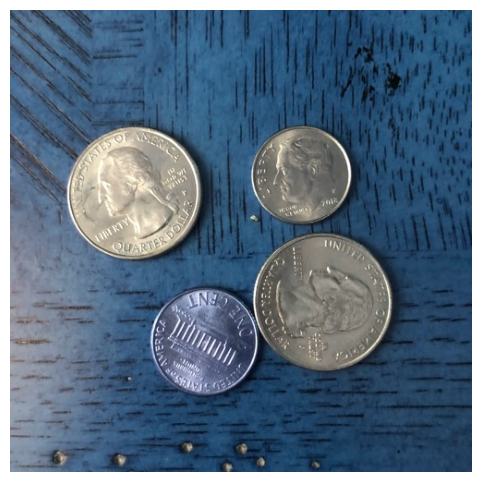

There are 4 coins in the image. 

I can see:

*   Two quarters
*   One penny
*   One quarter


In [16]:
# Format message with the aya-vision chat template
counting_image_url = "https://i1.sndcdn.com/artworks-000631939663-rvxff5-t500x500.jpg"
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {"role": "user",
     "content": [
       {"type": "image", "url": counting_image_url},
        {"type": "text", "text": "How many coins are there in the image?"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt").to(model.device, dtype=torch.bfloat16)
input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=1000, do_sample=False).to(model.device)
    generation = generation[0][input_len:]

text_response = processor.decode(generation, skip_special_tokens=True)

response = requests.get(counting_image_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(text_response)

# OCR

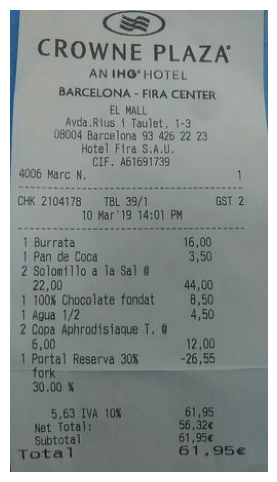

Okay, here's a structured breakdown of the information from the receipt image:

**Receipt Details**

*   **Restaurant:** Crowne Plaza An IHG Hotel
*   **Location:** Barcelona - Fira Center
*   **Date/Time:** 10 Mar '19 14:01 PM
*   **Check Number:** CHK 2104178
*   **VAT (IVA):** 10%
*   **Total:** 61,95€

**Items Purchased:**

| Item                     | Quantity | Price (€) |
| ------------------------ | -------- | --------- |
| Burrata                  | 1        | 16.00     |
| Pan de Coca              | 1        | 3.50      |
| Solomillo a la Sal       | 1        | 22.00     |
| 100% Chocolate Fondant   | 1        | 8.50      |
| Agua 1/2                 | 1        | 4.50      |
| Copa Aphrodisiaque T.    | 1        | 12.00     |
| Portal Reserva 30%       | 1        | -26.55    |
| Fork                     | 1        | 3.00      |

**Totals:**

*   **IVA (10%):** 5.63
*   **Net Total:** 56.32€
*   **Subtotal:** 61.95€
*   **Total:** 61,95€

Let me know if you'd like me to extrac

In [9]:
ocr_image_url = "https://media-cdn.tripadvisor.com/media/photo-s/16/c3/c0/e3/restaurant-receipt.jpg"

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {"role": "user",
     "content": [
       {"type": "image", "url": ocr_image_url},
        {"type": "text", "text": "Extract the text from the image and return a structured output, extract the prices, item, total, and quantity"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt").to(model.device, dtype=torch.bfloat16)
input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=1000, do_sample=False).to(model.device)
    generation = generation[0][input_len:]

text_response = processor.decode(generation, skip_special_tokens=True)

response = requests.get(ocr_image_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(text_response)


# VQA

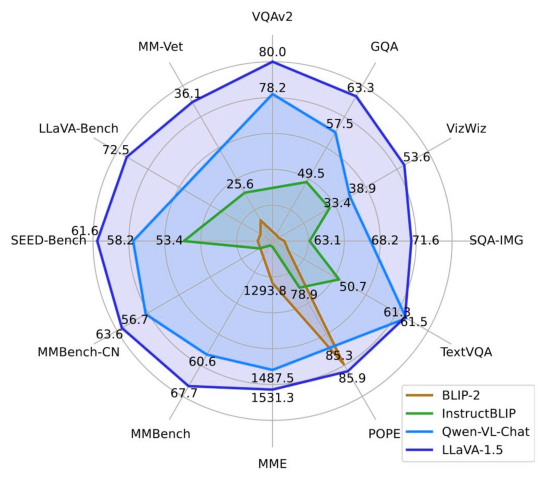

Based on the radar chart, **LLaVA-Bench** has the second best performance in the LLAVA-Bench benchmark. It's represented by the orange line, which is slightly below the top-performing model (LLaVA-1.5).


In [11]:
vqa_url = "https://raw.githubusercontent.com/haotian-liu/LLaVA/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg"
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {"role": "user",
     "content": [
       {"type": "image", "url": vqa_url},
        {"type": "text", "text": "Which model has the second best performance in LLAVA-Bench"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt").to(model.device, dtype=torch.bfloat16)
input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=1000, do_sample=False).to(model.device)
    generation = generation[0][input_len:]

text_response = processor.decode(generation, skip_special_tokens=True)

response = requests.get(vqa_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(text_response)


# Image captions

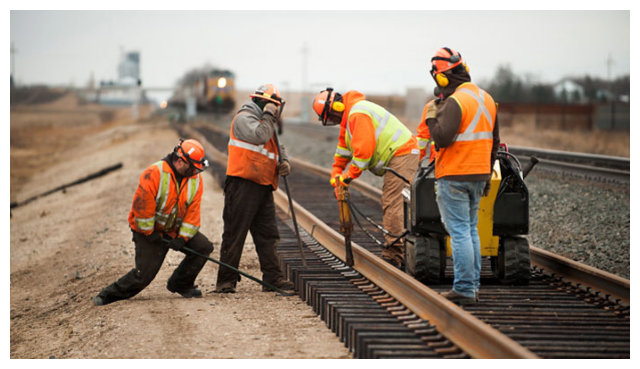

Here are a few caption options for the image, ranging in tone and length:

**Option 1 (Descriptive):**

"Construction crews work diligently to lay new railroad tracks, ensuring a safe and efficient transportation network. Safety gear is prioritized with hard hats and reflective vests."

**Option 2 (Focus on the work):**

"Building the future of freight: Railroad workers meticulously install new track segments, a vital part of infrastructure development."

**Option 3 (Short & impactful):**

"Railroad construction in progress.  Building the tracks ahead."

**Option 4 (A bit more evocative):**

"The steady rhythm of progress – railroad workers laying the foundation for movement and connection."

---

Would you like me to generate captions with a specific focus (e.g., highlighting teamwork, the importance of infrastructure, or a particular aspect of the scene)?


In [12]:
image_caption_url = "https://www.minneapolisfed.org/-/media/images/pubs/fedgaz/15-04/key-images/working-on-the-railroad-key.jpg"
messages = [
    {"role": "user",
     "content": [
       {"type": "image", "url": image_caption_url},
        {"type": "text", "text": "Generate a caption for the image"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt").to(model.device)
input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=1000, do_sample=False).to(model.device)
    generation = generation[0][input_len:]

text_response = processor.decode(generation, skip_special_tokens=True)

response = requests.get(image_caption_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(text_response)
